In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import env

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# acquire the data
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [4]:
# convert the date to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   request_method  13978 non-null  object
 2   request_path    13978 non-null  object
 3   http_version    13978 non-null  object
 4   status_code     13978 non-null  object
 5   size            13978 non-null  int64 
 6   user_agent      13978 non-null  object
dtypes: int64(1), object(6)
memory usage: 873.6+ KB


In [6]:
# create a new column that converts sixe into MB
df['size_mb'] = df['size'] / 1024 / 1024

In [7]:
df.describe()

,size,size_mb
count,1.397800e+04,13978.000000
mean,4.500019e+05,0.429155
std,1.614915e+05,0.154010
min,0.000000e+00,0.000000
25%,5.006370e+05,0.477445
50%,5.101380e+05,0.486506
75%,5.112910e+05,0.487605
max,2.056327e+06,1.961066


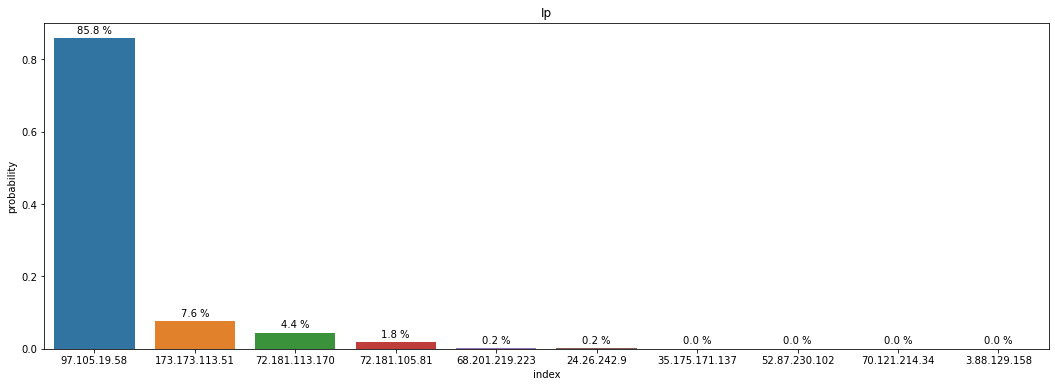

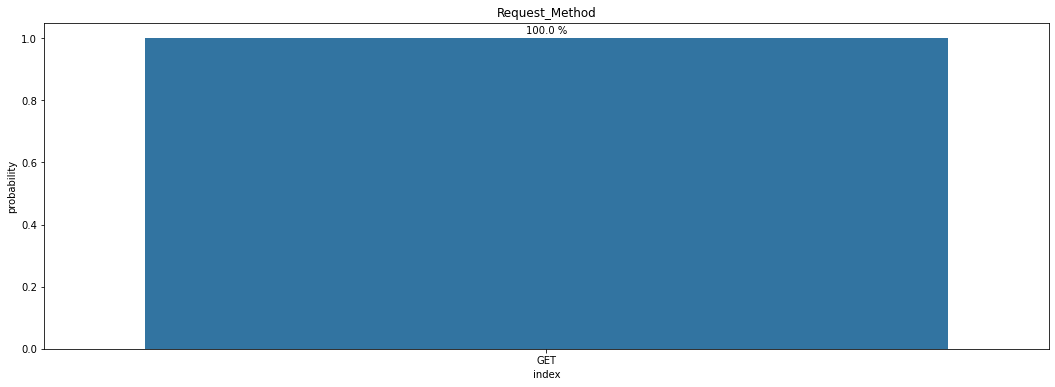

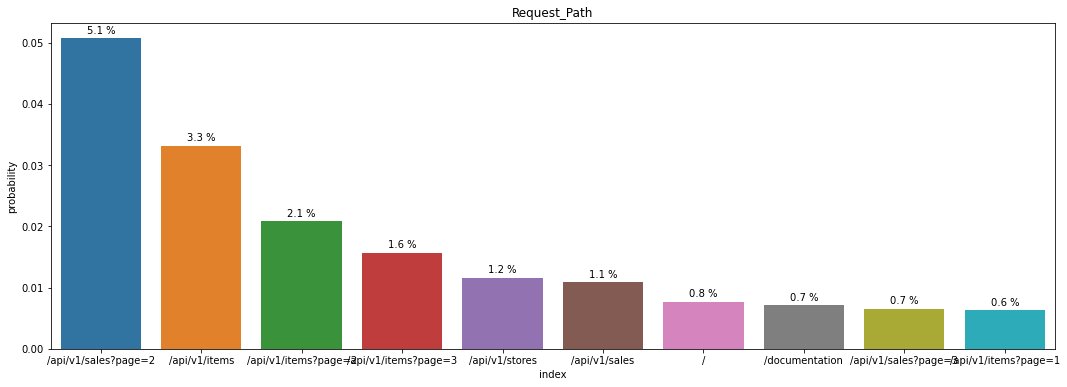

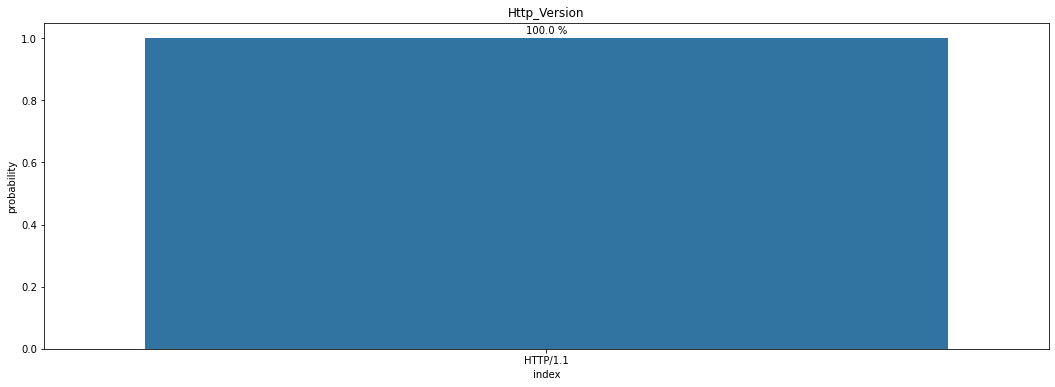

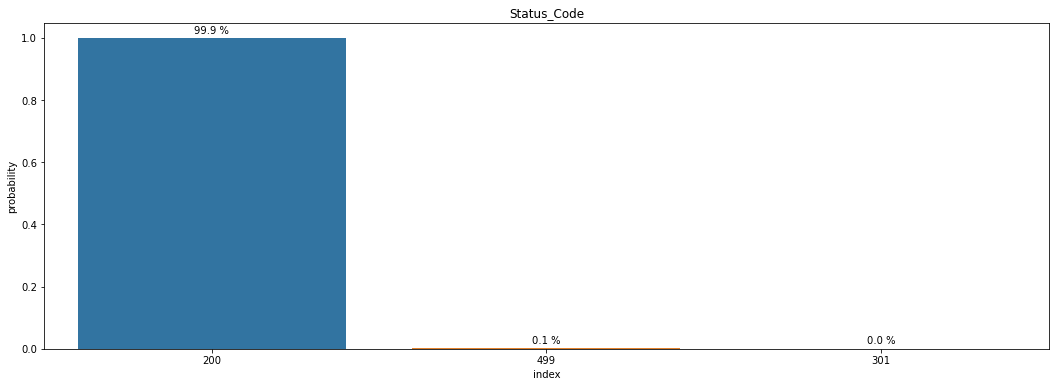

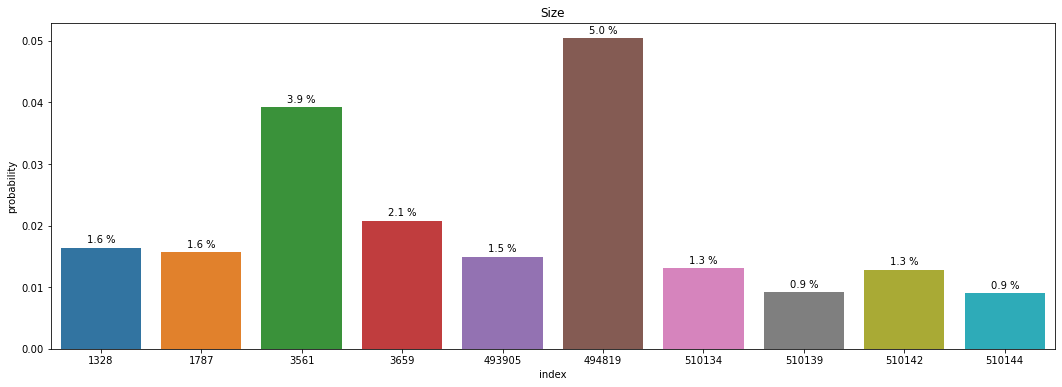

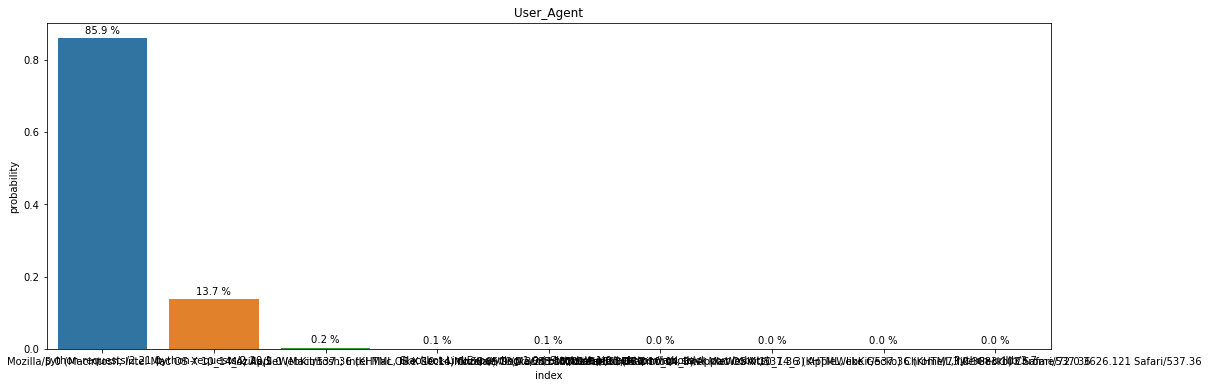

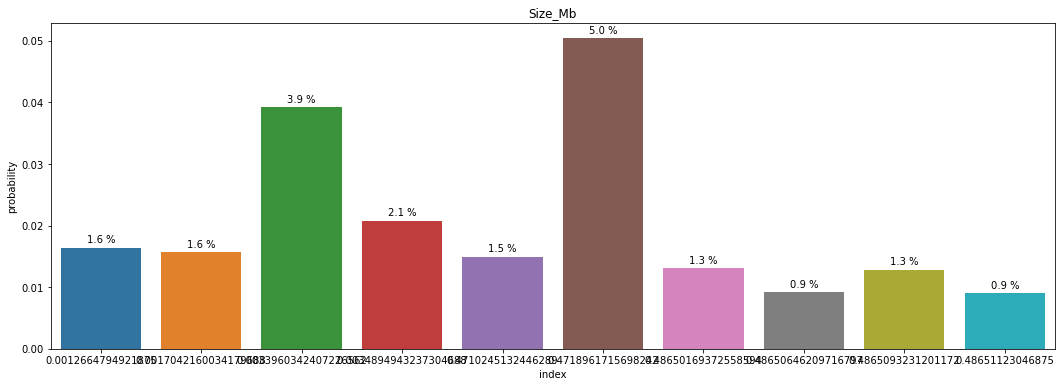

In [8]:
# create a visualization of the data
for col in df.columns:
    plt.figure(figsize=(18, 6))
    splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

In [9]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [10]:
# value counts of unique ip addresses
df_ip = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [11]:
# determine the probability of an ip address
df_ipp = pd.DataFrame(df.ip.value_counts(dropna = False)/df.ip.count()).reset_index().rename(index = str , columns = {'index':'ip','ip':'ip_proba'})

In [12]:
# combine the two dataframes
ip_df = df_ip.merge(df_ipp)

In [13]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ip        22 non-null     object 
 1   ip_count  22 non-null     int64  
 2   ip_proba  22 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes


In [14]:
# combine new data with the original data
df_merged = df.merge(ip_df, on='ip', how='left')

In [15]:
# look at probabilities less than 1%
df_merged[df_merged.ip_proba < 0.01].groupby('ip').count()

,request_method,request_path,http_version,status_code,size,user_agent,size_mb,ip_count,ip_proba
ip,,,,,,,,,
24.26.242.9,21,21,21,21,21,21,21,21,21
3.88.129.158,1,1,1,1,1,1,1,1,1
3.92.201.136,1,1,1,1,1,1,1,1,1
34.207.64.242,1,1,1,1,1,1,1,1,1
34.229.70.250,1,1,1,1,1,1,1,1,1
35.174.209.2,1,1,1,1,1,1,1,1,1
35.175.171.137,2,2,2,2,2,2,2,2,2
45.23.250.16,1,1,1,1,1,1,1,1,1
52.87.230.102,2,2,2,2,2,2,2,2,2


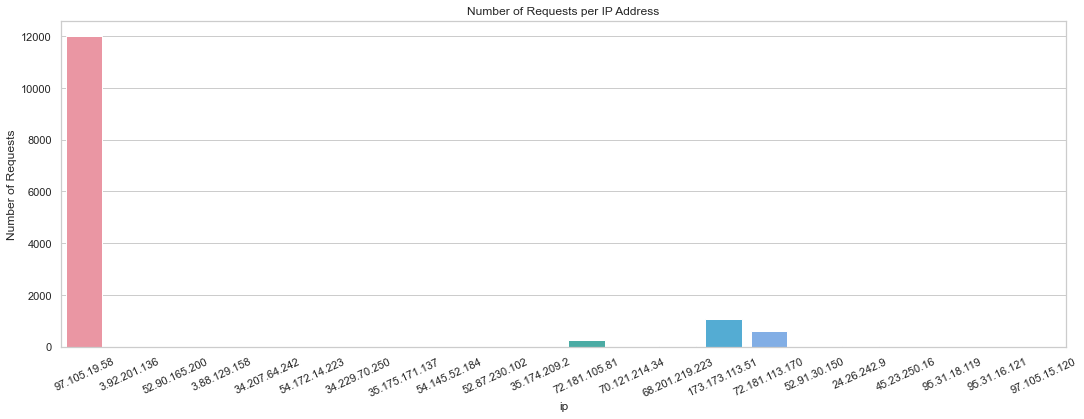

In [16]:
# use seaborn to plot the number of requests per ip address
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))
sns.barplot(x='ip', y='ip_count', data=df_merged)
plt.title('Number of Requests per IP Address')
plt.ylabel('Number of Requests')
plt.xticks(rotation=25)
plt.show()


In [19]:
# look at one year of data
train = df[df.index.year == 2019]

In [20]:
# only look at the columns we need
train = train[['ip','request_method','status_code','user_agent','size_mb']]

In [23]:
# determine the probability of an ip address from train data
ip_train = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [25]:
ip_train

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502
5,24.26.242.9,0.001502
6,35.175.171.137,0.000143
7,52.87.230.102,0.000143
8,70.121.214.34,0.000143
9,52.90.165.200,0.000072


In [26]:
# merge onto original dataframe to "predict" probabilities. fill nulls with 0 
df = df.reset_index().merge(ip_train, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip_proba.value_counts()


0.858420    11999
0.075762     1059
0.043855      613
0.017599      246
0.001502       42
0.000072       13
0.000143        6
Name: ip_proba, dtype: int64

In [27]:
# look at the ip probabilities for analysis
ip_probs = train.groupby('ip').size().div(len(df))

In [28]:
ip_probs

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
95.31.16.121      0.000072
95.31.18.119      0.000072
97.105.15.120     0.000072
97.105.19.58      0.858420
dtype: float64

In [30]:
# group by ip and status, then get the probabilites and save the results in a column
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status_code']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [31]:
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000
